##  Chapter 11: Linear unsupervised learning

# 11.3  Feature scaling via ZCA sphereing

Once we have derived PCA we will then discuss a number of popular applications of the technique - with an emphasis on two major areas.  The first application is to supervised learning datasets, where PCA is used to learn a complete $K=N$ dimensional spanning set for use as an advanced version of *feature scaling* / *data normalization*.  This is typically referred to as *sphereing*.  For unsupervised learning datasets, that is data consisting of input points alone, PCA is often used to learn a lower dimensional $K < N$ representation that is easier for human beings to interpret.

In [2]:
# This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ortho_group  # Requires version 0.18 of scipy

# custom libs
from mlrefined_libraries import unsupervised_library as unsuplib
from mlrefined_libraries import basics_library as baslib
datapath = '../../mlrefined_datasets/unsuperlearn_datasets/'
from mlrefined_libraries import superlearn_library as superlearn
normalizers = superlearn.normalizers 

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 11.3.1  Feature scaling by PCA sphereing

Previously we have seen  with linear regression / classification how normalizing a dataset - by subtracting off the mean and dividing by the standard deviation along each of its feature dimensions - helps dramatically improve (or *condition*) the contours of a cost function, allowing gradient and coordinate descent methods to converge much faster than they typically would otherwise.

The spanning set provided by Principal Component Analysis is often used to perform this sort of normalization to supervised learning data as well - but actually goes one step further.  Because the principal components identify the orthogonal directions of greatest variance, and the transformed feature space provided by them is a perfect copy of our data rotated such that these directions align with the coordinate axes, normalizing the transformed feature space along each coordinate axes can better compact-ify our data.  For the same reasons as we have seen with the standard normalization scheme, this can greatly improve the convergence of gradient / coordinate descent.  This type of normalization - which again is used very often for supervised learning problems - is called *sphereing* (or also synonymously called *whitening*).

Since each data point is represented by $\hat{\mathbf{w}}_p = \mathbf{V}_{\,}^T\mathbf{x}_p^{\,}$ in the space spanned by the principal components, we can represent the entire set of transformed data as 

\begin{equation}
\text{(PCA transformed data)}\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\mathbf{W} = \mathbf{V}^T\mathbf{X}^{\,}.
\end{equation}

Now we aim to normalize each column of the transformed data $\mathbf{W}$.  Since these transformed features were built from a mean-centered dataset the columns of $\mathbf{W}$ are mean-centered themselves, so all that remains is to divide off the standard deviation of each column.  

This can be done in the typical way numerically - or to save computation we can conveniently the unnormalized variance of each column of $\mathbf{W}$ has already been computed in the eigen-decomposition of the regularized covariance matrix $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T + \lambda \mathbf{I}_{N\times N}$: these are precisely the eigenvalues (as mentioned in the derivation above).  In other word, since $d_n$ is the variance along the $n^{th}$ axis defined by the $n^{th}$ eigenvector $\mathbf{v}_n$ the corresponding standard deviation can be computed as its square root $\left(d_n\right)^{^1/_2}$.  So denoting $\mathbf{D}^{-^1/_2}$ the diagonal matrix whose $n^{th}$ entry is $\left(d_n\right)^{^1/_2}$, we can divide off the standard deviation each column of $\mathbf{W}$ by e.g.,
 left-multiplying by as

\begin{equation}
\text{(PCA-sphered data)}\,\,\,\,\,\,\,\,\, \mathbf{S}^{\,} = \mathbf{D}^{-^1/_2}\mathbf{W}^{\,} =  \mathbf{D}^{-^1/_2}\mathbf{V}^T\mathbf{X}^{\,}.
\end{equation}

<figure>
  <img src= '../../mlrefined_images/unsupervised_images/pca_sphereing.png' width="200%"  height="auto" alt=""/>
  <figcaption>   
<strong>Figure 1:</strong> <em> PCA-sphereing illustrated. </em>  </figcaption> 
</figure>

Once sphered notice that - as indicated in the figure - that 

- the data has been rotated such that the orthogonal directions of greatest variance now align with the coordinate axes

- our standard normalization (division by the standard deviation) is then performed along each axis

- after being PCA-sphered the data has unit-length covariance along each transformed input dimension: i.e., $\frac{1}{P}\mathbf{S}^{\,}\mathbf{S}^T = \mathbf{I}_{N\times N}$

A ``Python`` function for performing sphereing - based off the functionality previously provided - is below. 

In [6]:
def PCA_sphere(X,**kwargs):
    '''
    A function for producing the full PCA sphereing on an input dataset X.  
    '''
    # compute principal components
    W,V,D = pca_transform_data(X,**kwargs)
    
    # compute transformed data for PC space: V^T X
    W = np.dot(V.T,X)
    D_ = np.array([1/d**(0.5) for d in D])
    D_ = np.diag(D_)
    S = np.dot(D_,W)
    return W,S

With this function defined we can try it out on a sample dataset used in e.g., the previous example.  The next cell runs the sphereing code above, and plots comparisons of the a) the original mean-centered data (left panel), b) the PCA-transformed data (middle panel), and c) sphered data (right panel).  Here sphereing drastically improved the distribution of the original dataset, which (if this were a supervised learning dataset) will drastically improve our ability to quickly tune the parameters of a supervised model via gradient / coordinate descent.

<IPython.core.display.Javascript object>


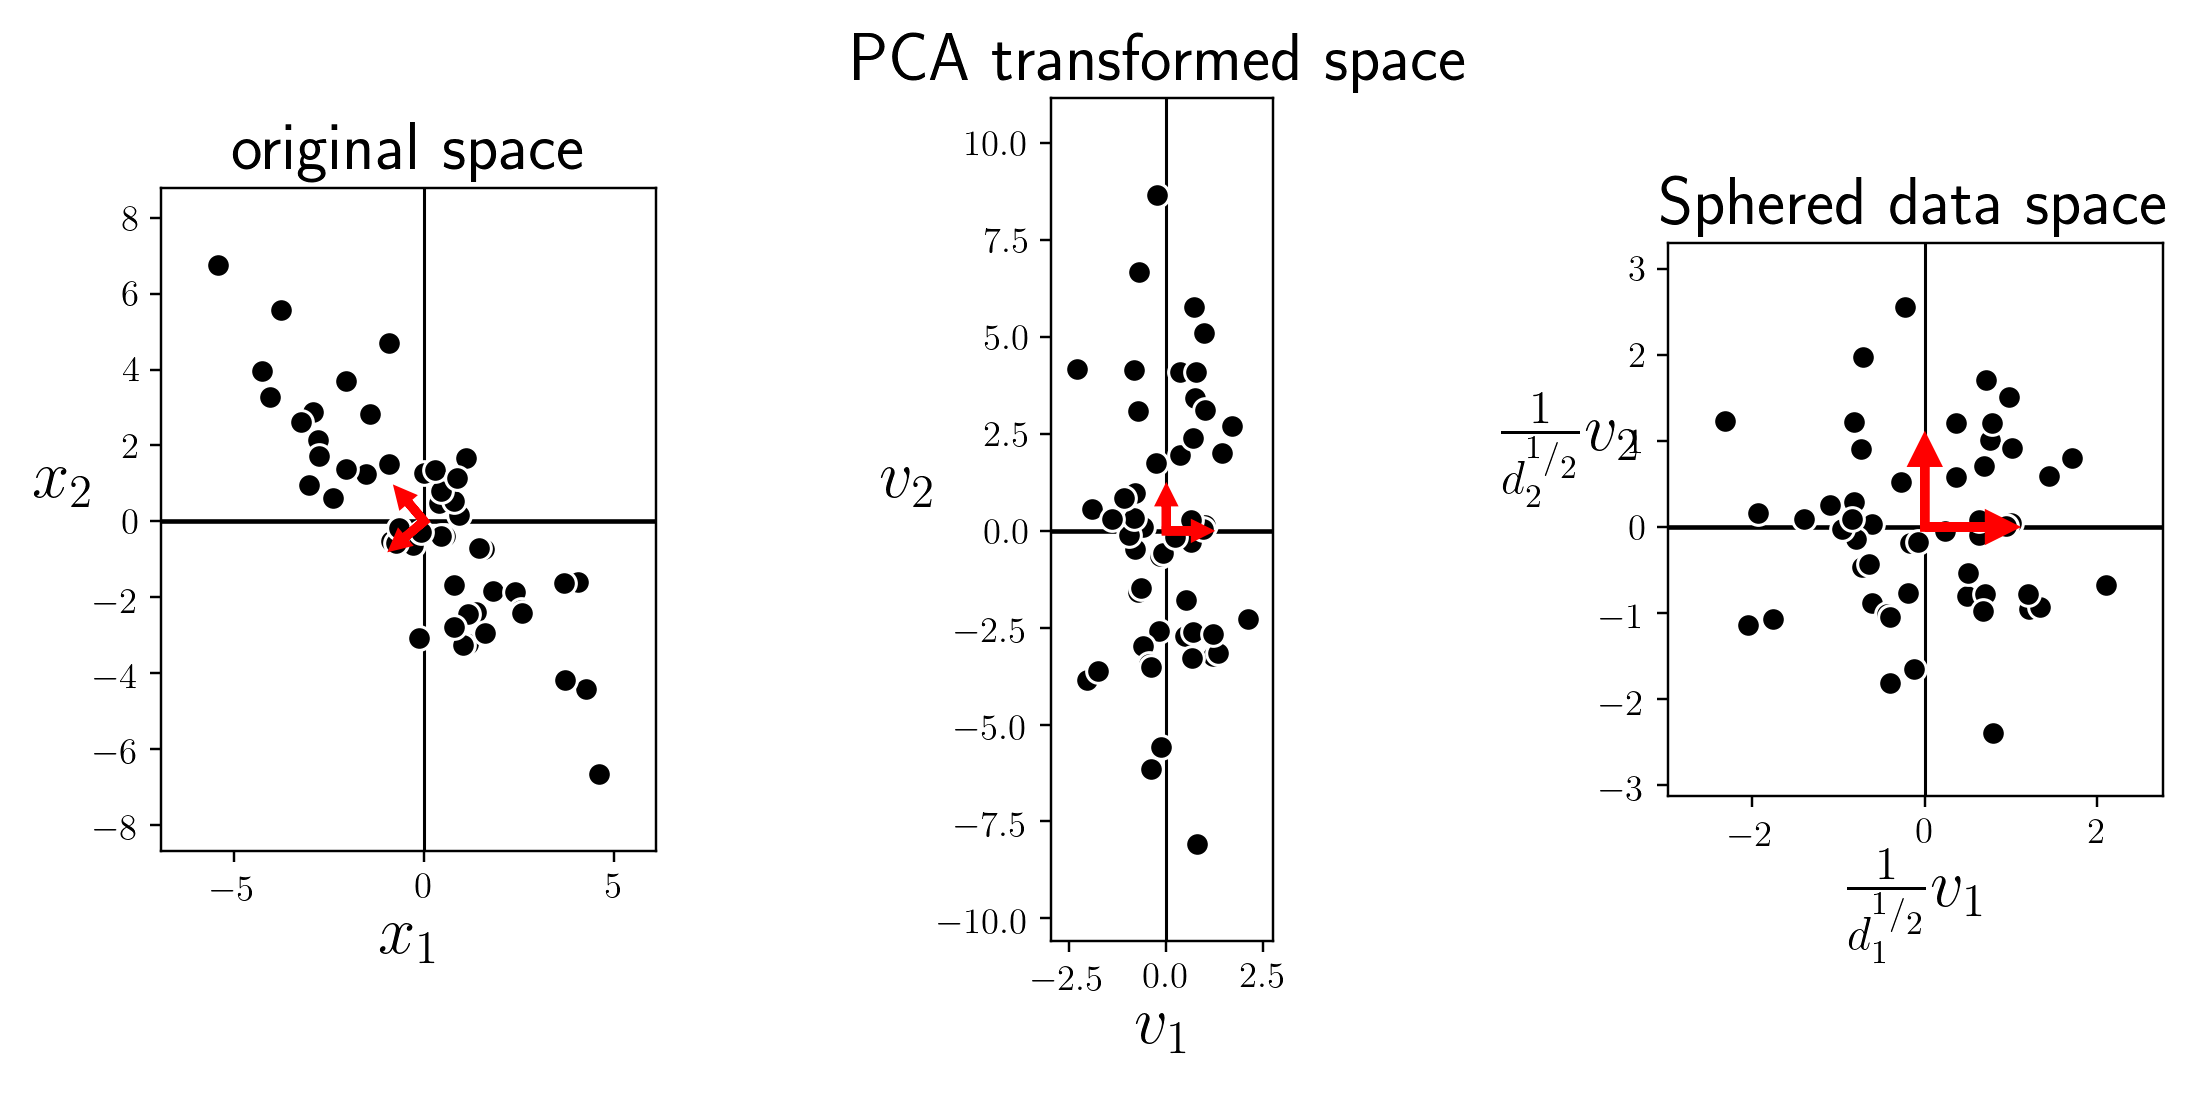

In [101]:
# load in dataset to perform PCA on
X_original = np.loadtxt(datapath + '2d_span_data.csv',delimiter=',')

# mean-center the data
X = center(X_original)

# compute the full PCA transformation of dataset
W,S = PCA_sphere(X)

# compute principal components
unsuplib.PCA_demos.sphereing_visualizer(X,W,S,pcs)

## 11.3.2 Feature scaling by Zero-phase Component Analysis (ZCA) sphereing

The PCA-based sphereing detailed in the previous example is generally applicable to any generic kind of data.  However in the case of images, videos, and other types of data that has inherent local *spatial correlation* structure (e.g., in an image pixels near one another are highly correlated in terms of the intensity values) we often look to leverage this special structure to improve the generalizability of a trained supervised learner.  For example in the case of image-data a carefully designed extensions of the supervised learning framework we have seen thus far - e.g., *edge detectors* more generally a *convolutional network* - are built specifically to leverage the spatial correlation in an image.  Because of this, while we would still like to employ some sort of data normalization (an important engineering factor we always aim to employ in practice, as it greatly quickens the training process), we need to make sure that our data-normalization procedure will not destroy the spatial correlation we aim to explicitly leverage via e.g., edge detectors or convolutional operations.  Does PCA-sphereing fit this bill?  

To find out we perform PCA-sphereing on a set of standard handwritten digits - a random subset of 5,000 the MNIST dataset each 28x28 pixels in length/width.  Because images are visual pieces of data we can compare data points visually before and after the PCA-sphereing process.

In the next cell we load in this dataset, and plot a sample of the MNIST dataset.

In [3]:
# load in dataset
datapath = '../../mlrefined_datasets/superlearn_datasets/'
data = np.loadtxt(datapath + 'mnist_mini_train.csv',delimiter = ',')

# divy up data into images and labels
images = data[:,:-1].T
labels = data[:,-1]

OSError: ../../mlrefined_datasets/superlearn_datasets/mnist_mini_train.csv not found.

<IPython.core.display.Javascript object>


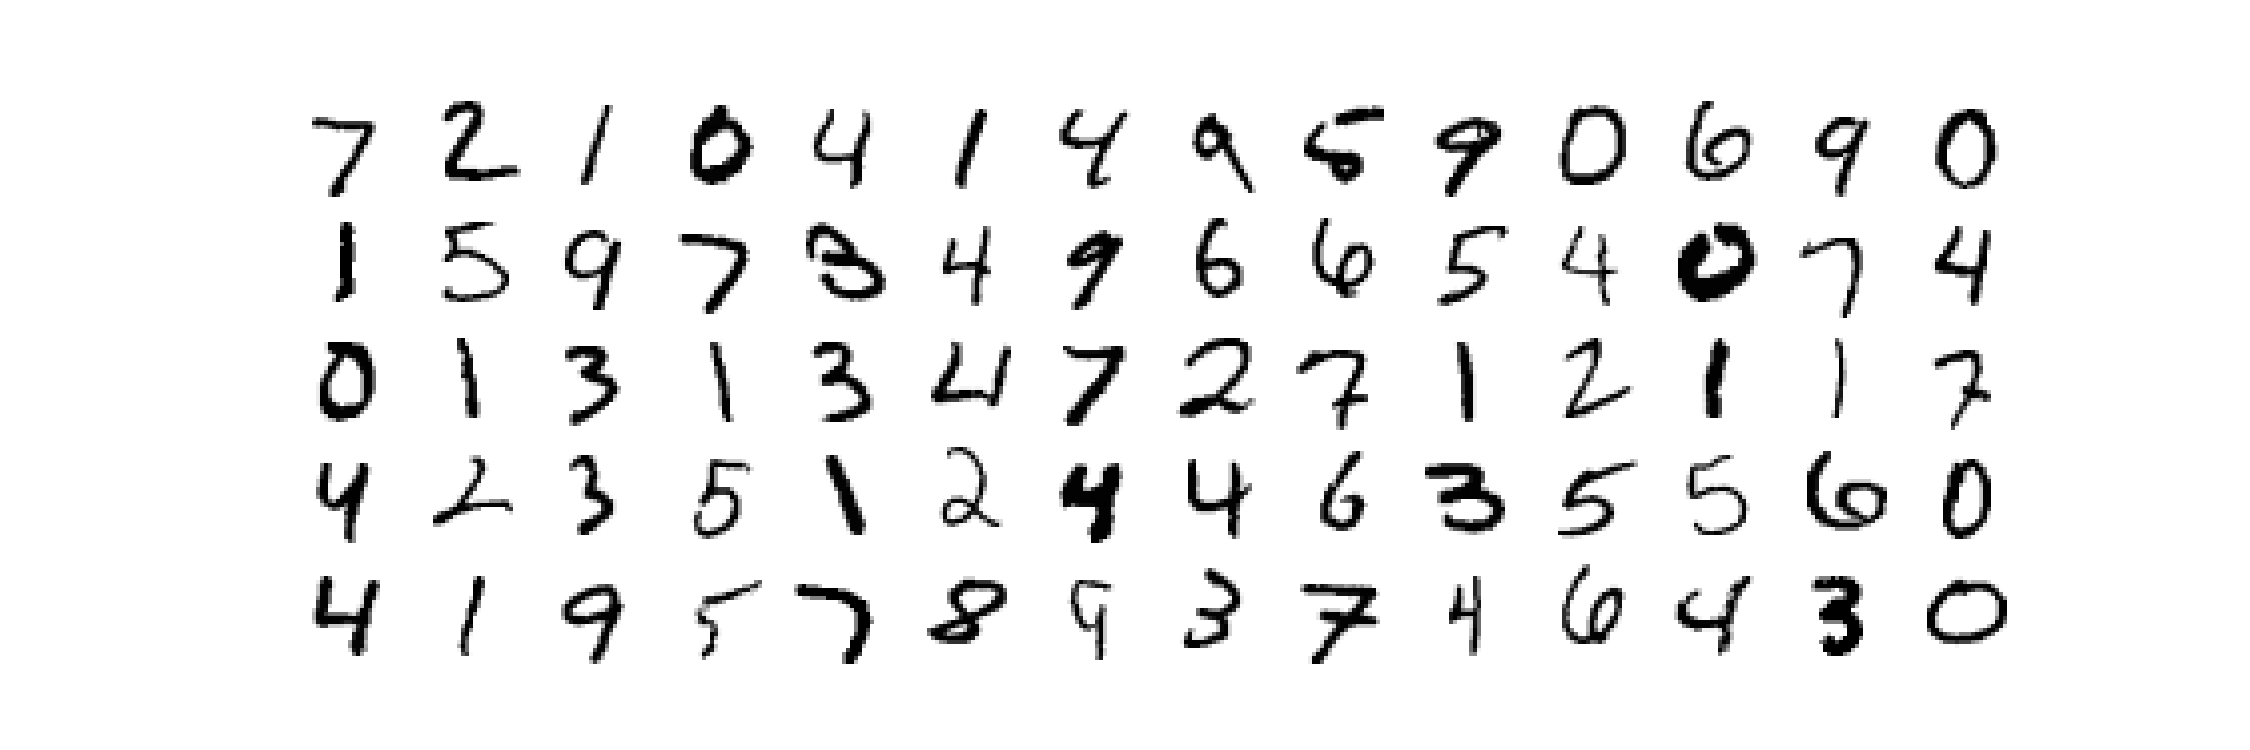

In [71]:
# plot a sample of the images
unsuplib.PCA_functionality.show_images(images)

Now we perform PCA-sphereing on this handwritten digit dataset, and plot the resulting PCA-sphered data.  Note: these are the same data points (transformed by the sphereing process, of course) we plotted above.

<IPython.core.display.Javascript object>


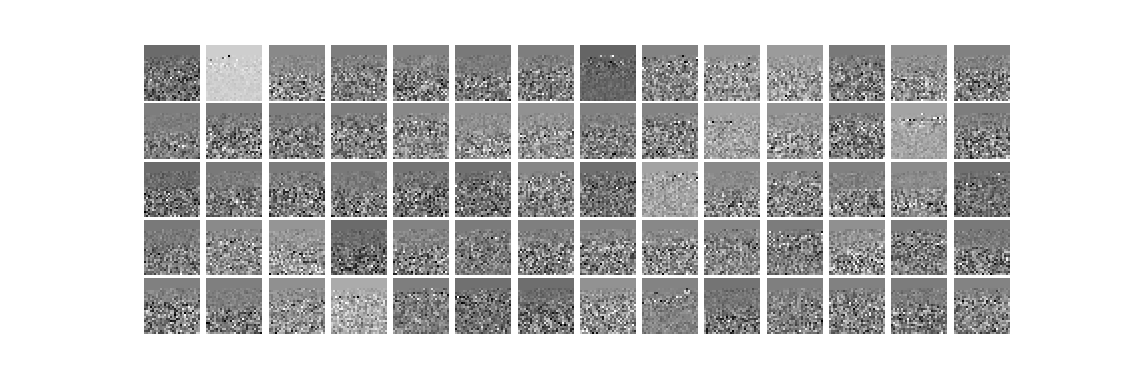

In [245]:
# mean-center the data
X = center(images)

# compute the full PCA transformation of dataset
W,S = PCA_sphere(X)

# plot PCA-sphered data
unsuplib.PCA_functionality.show_images(S)

In this instance PCA-sphereing completely destroys the spatial structure of the original images - none of the original numbers are visible in these transformed versions.  This phenomenon is true more generally: PCA-sphereing tends to destroy the spatial correlation of images, video, etc.,  What about the sphereing process we have applied is responsible for this?

As detailed in the previous Example, in terms of the actions we perform on the data itself with PCA-sphereing (or whitening) we:

- **rotate and reflect** by multiplying the data by $\mathbf{V}^T$ (where $\mathbf{V}$ is the set of eigenvectors of the data's covariance matrix) the data so that its largest orthogonal directions of variance align with the coordinate axes (this is done by the standard PCA transformation)

- **normalize** these coordinate axes by dividing by their individual standard deviations by multiplying the rotated/reflected data by $\mathbf{D}^{-^1/_2}$, the diagonal matrix of inverted square roots of the eigenvalues of the data's covariance matrix (this extra bit of normalization added to the PCA transformation to makes it the PCA-sphereing operation)

Both of these actions contribute to the destruction of spatial correlation - but it is the **rotation / reflection** component that is by far the greater culprit.  We can get a visceral sense of this fact with our current dataset by simply applying the standard PCA transform - which will rotate / reflect the space so that the largest directions of variance coincide with the coordinate axes - without normalizing the result (which led to the PCA-sphereing result above).   We do this in the next cell, and plot the resulting transformed images.

<IPython.core.display.Javascript object>


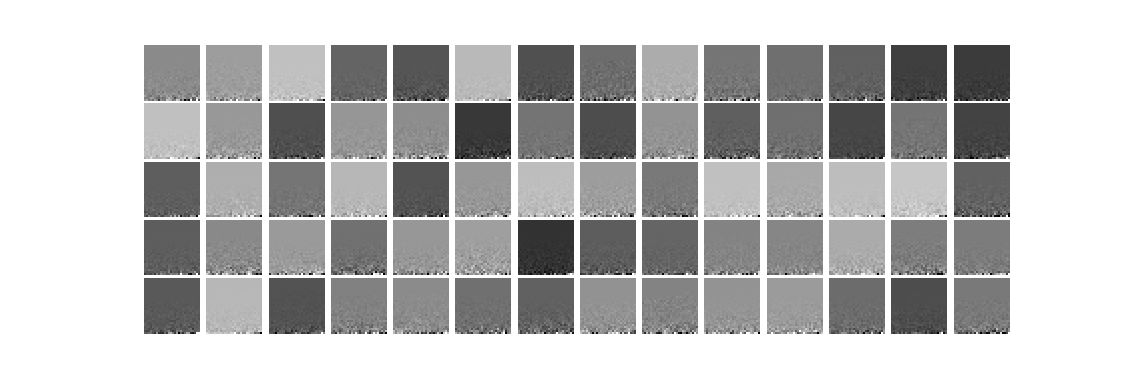

In [246]:
# mean-center the data
X = center(images)

# compute the full PCA transformation of dataset
W,V,D = pca_transform_data(X)

# plot PCA-sphered data
unsuplib.PCA_functionality.show_images(W)

As we can see in the examples plotted above, the rotation / reflection from PCA transformation utterly - created by multiplying our data by $\mathbf{V}^T$ - utterly destroys the spatial correlation structure of our images, a phenomenon that is true more generally speaking for other image datasets as well.  What can we do if we would still like the added optimization-boosting benefit of PCA-sphereing normalization but do not want to destroy the spatial correlation of our input data by rotating / reflecting it?  Well if indeed the rotation / reflection is producing the greatest challenge in terms of maintaining the spatial correlation of our data, why don't we simply rotate / reflect our dataset back to its original orientation after we finish sphereing it (i.e.,normalizing it along its largest orthogonal directions of variance)?  Since we know that it multiplication by $\mathbf{V}^T$ that produces the original rotation / reflection, multiplying by PCA-sphered data by $\left(\mathbf{V}^T\right)^{-1} = \mathbf{V}^{\,}$ (where the equality follows from the fact that $\mathbf{V}$ is an orthogonal matrix) will return the sphered data to its original orientation in the space.  This is illustrated in the Figure below.

<figure>
  <img src= '../../mlrefined_images/unsupervised_images/zca_sphereing.png' width="110%"  height="auto" alt=""/>
  <figcaption>   
<strong>Figure 2:</strong> <em> ZCA-sphereing illustrated. </em>  </figcaption> 
</figure>

Since our PCA-sphered transformation of the input data took the form $\mathbf{S}^{\,} =  \mathbf{D}^{-^1/_2}\mathbf{V}^T\mathbf{X}^{\,}$ this re-rotation/reflection gives us the related formula

\begin{equation}
\text{(ZCA-sphered data)}\,\,\,\,\,\,\,\,\, \mathbf{Z}^{\,} =  \mathbf{V}\mathbf{S} = \mathbf{V}\mathbf{D}^{-^1/_2}\mathbf{V}^T\mathbf{X}^{\,}.
\end{equation}

For historical reasons this re-rotated version of our PCA-sphered data is often referred to as *Zero-phase Component Analysis (ZCA) sphereing*.  

We implement ZCA-sphereing in the next cell.

In [247]:
def ZCA_sphere(X,**kwargs):
    '''
    A function for producing the ZCA sphereing on an input dataset X.  
    '''   
    
    # compute principal components
    W,V,D = pca_transform_data(X,**kwargs)
    
    # PCA-sphere data
    W = np.dot(V.T,X)
    D_ = np.array([1/d**(0.5) for d in D])
    D_ = np.diag(D_)
    S = np.dot(D_,W)
    
    # rotate data back to original orientation - ZCA sphere
    Z = np.dot(V,S)
    
    return W,S,Z

With our ZCA-sphereing implementation written we can now transform the original centered dataset using it and examine the results.

<IPython.core.display.Javascript object>


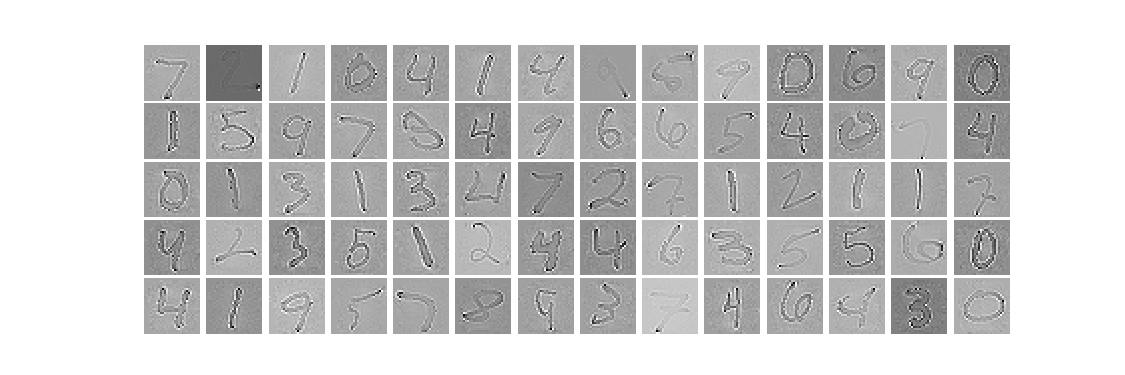

In [248]:
# mean-center the data
X = center(images)

# compute the full PCA transformation of dataset
W,S,Z = ZCA_sphere(X)

# plot PCA-sphered data
unsuplib.PCA_functionality.show_images(Z)

What a difference!  Indeed it was the rotation/reflection of PCA that destroyed most of the spatial correlation, since these ZCA-sphered images retain much of the spatial correlation present in their original versions.  Now we have the best of both worlds: a global normalization scheme (that will help speed up training) that retains the spatial structure of data leveraged e.g., by edge detectors and convolution operations.